Filename: btcmbin_HIPASSJ0459-26_Maj.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (3172, 960)   float32   


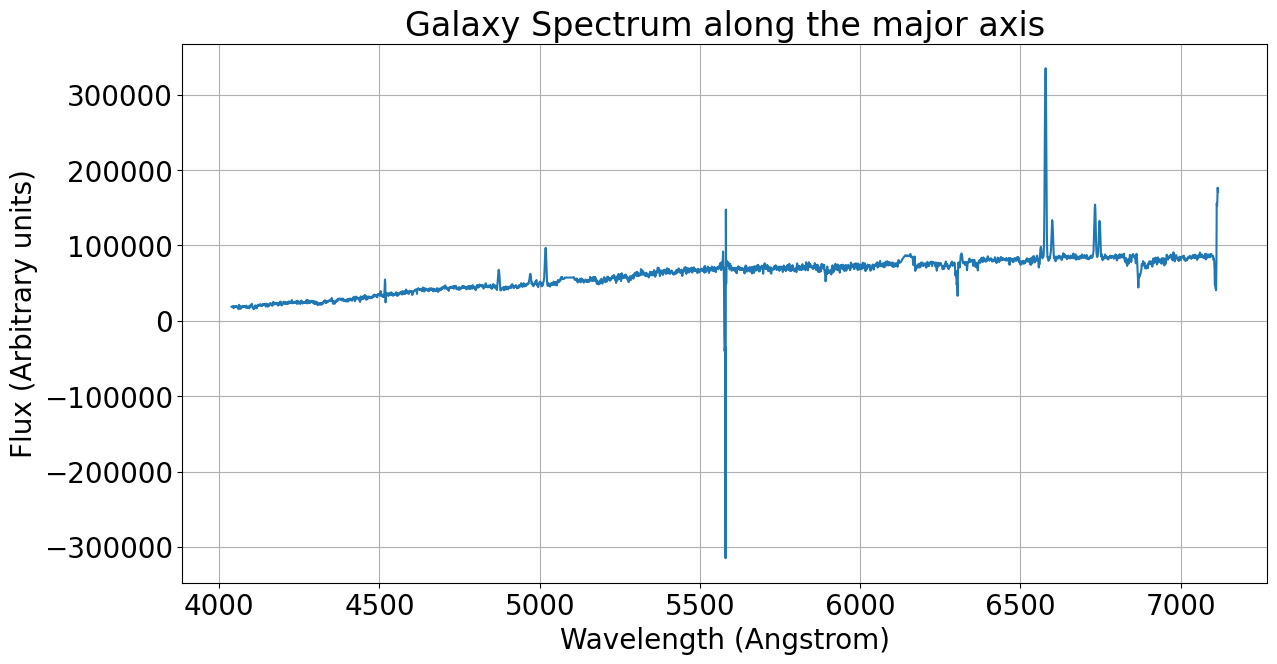

In [3]:
# NGWTHO016
# Thobile Ngwenya

from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from astropy import constants
from astropy import units as u
plt.rcParams.update({'font.size': 20})
c = constants.c.value*1e-3*(u.km/u.s)
# Open the FITS file
file_path = 'btcmbin_HIPASSJ0459-26_Maj.fits'
hdul = fits.open(file_path)

# Print the structure of the file (optional, to check HDUs)
hdul.info()

# Assuming the data is in the primary HDU
data = hdul[0].data
header = hdul[0].header

# Guassian fit
def gaussian(x, a, mean_data, standard_dev, b):
    return a + b * np.exp(-(x - mean_data) ** 2 / (2 * standard_dev ** 2))

spectrum = np.sum(data, axis=0)

scale = header.get('CDELT1', 1.0)
offset = header.get('CRVAL1', 0.0)

wavelength = np.arange(len(spectrum)) * scale + offset


plt.figure(figsize = (14,7), facecolor = 'white')
plt.plot(wavelength, spectrum)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (Arbitrary units)')
plt.title('Galaxy Spectrum along the major axis')
plt.grid()
#plt.savefig('spectrum')
plt.show()

Velocity at new_pos = 0: 741.4952349849626 km/s
3.545630853786668


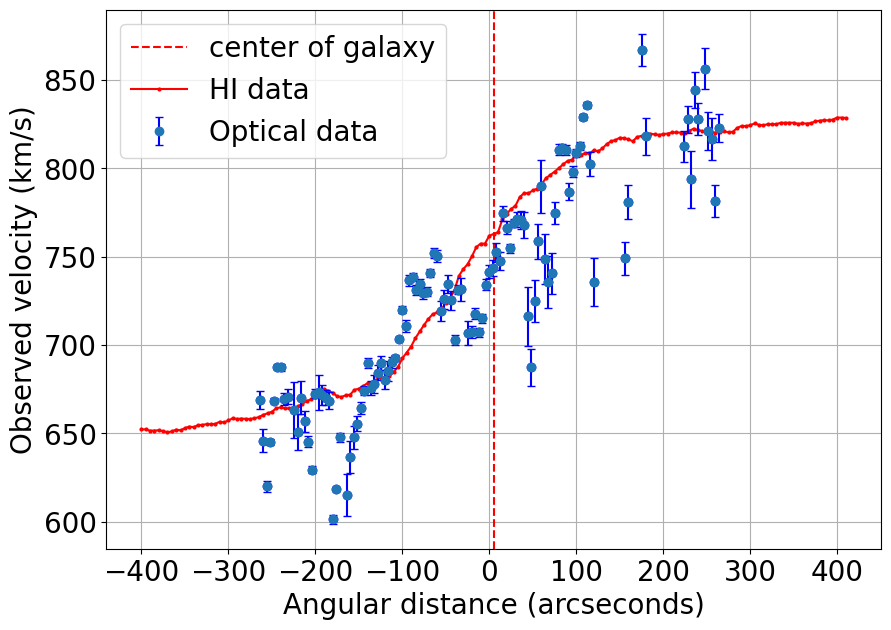

In [4]:
halpha_rest = 6562.61
halpha_expected = 0.002472*6562.61 + 6562.61
alpha_range = 100
velocities = []
velocity_errors = []
position = []

# range to perform the fit on
wave_range = (wavelength > (halpha_expected - alpha_range)) & (wavelength < (halpha_expected + alpha_range))
noise_range = (wavelength < 4200) & (wavelength > 0)
wavelengths = wavelength[wave_range]

for i in range(200,800,4):
    spectrum_pos = data[i,:]+data[i+1,:]+data[i+2,:]+data[i+3,:]
    flux_fit = spectrum_pos[wave_range]
    flux_noise = spectrum_pos[noise_range]
    noise = np.std(flux_fit[0:20])

    # initial values
    p0 = [np.median(flux_fit[0:10]), wavelengths[np.argmax(flux_fit)], 5, np.max(flux_fit)]        # Use argmax to find mean corresponding to the peak flux

    try:
        popt, pcov = curve_fit(gaussian, wavelengths, flux_fit, p0=p0)
        offset, mu, sigma, a = popt

        if a >= 4*noise:
            velocity = c.value * (popt[1] - halpha_rest) / halpha_rest
            velocity_err = c.value * np.sqrt(pcov[1,1]) / halpha_rest

            if 900>velocity>500:
                velocities.append(velocity)
                velocity_errors.append(velocity_err)
                position.append(i)
                
#                 plt.figure(figsize = (16,9), facecolor = 'white')
#                 plt.plot(wavelengths, flux_fit, 'b-', label=f'data row{i}')
#                 plt.plot(wavelengths, gaussian(wavelengths, *popt), 'r-', label='Fit')
#                 plt.grid()
#                 plt.legend()
#                 plt.show()

        
    except RuntimeError:
        print(f'Fit failed for position {i+1}')

new_position = position - ((np.max(position) + np.min(position)) / 2)

filename = 'ds91.txt'
data = np.loadtxt(filename)

pos = data[:, 0]
vel = data[:, 1]

new_pos = pos - (np.max(pos) - np.min(pos)) / 2
new_vel = vel / 1000

zero_index = np.where(new_position == 0)[0][0]  # Find the index where new_pos equals 0
velocity_at_zero = velocities[zero_index]
vel_err = velocity_errors[zero_index]     # Extract the velocity at that index
print(f"Velocity at new_pos = 0: {velocity_at_zero} km/s")
print(vel_err)

plt.figure(figsize = (10,7), facecolor = 'white')
plt.plot(new_position, velocities, 'bo')
plt.axvline(x=5, color='r', linestyle='--', label='center of galaxy')
plt.plot(new_pos[:] * 5, new_vel[:], 'ro', linestyle='-', markersize=2, label='HI data')
plt.errorbar(new_position, velocities, yerr=velocity_errors, fmt='o', ecolor='blue', capsize=3, label='Optical data')
plt.ylabel('Observed velocity (km/s)')
plt.xlabel('Angular distance (arcseconds)')
plt.grid()
plt.legend()
plt.savefig('curve')
plt.show()


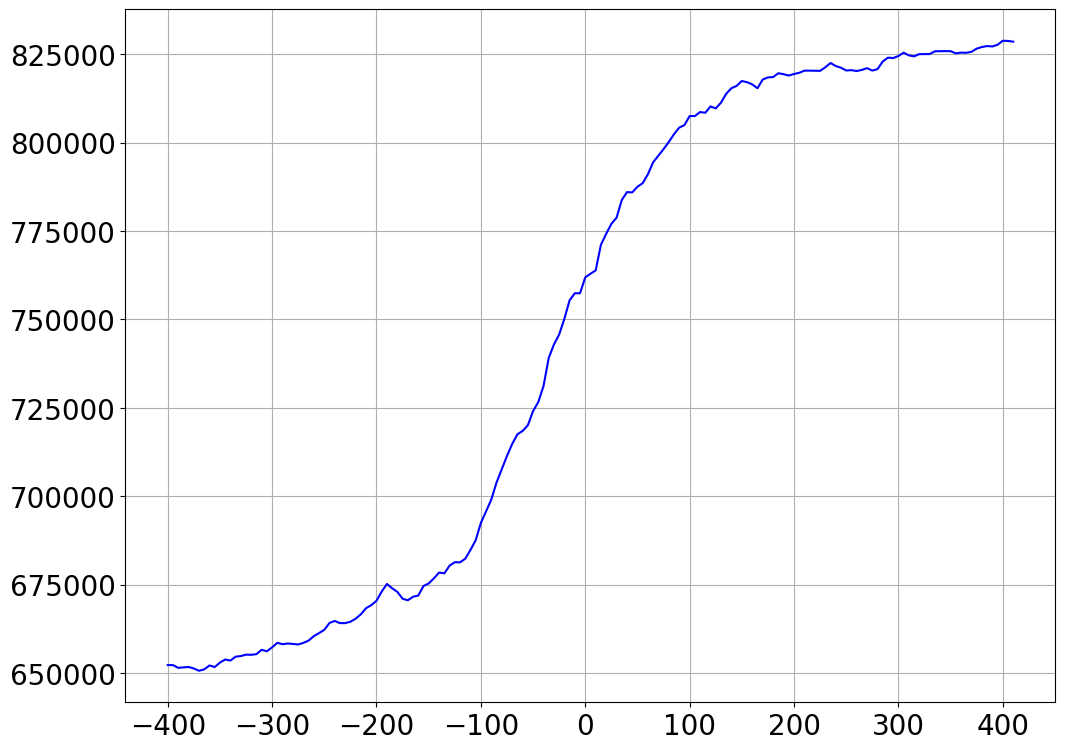

In [5]:
filename = 'ds91.txt'
data = np.loadtxt(filename)

pos = data[:, 0]
vel = data[:, 1]

new_pos = pos - (np.max(pos) - np.min(pos)) / 2
new_vel = vel

plt.figure(figsize=(12, 9))
plt.plot(new_pos * 5, new_vel, linestyle='-', color='b')
plt.grid()
plt.show()